In [1]:
import syft as sy
from utils import *
from syft.core.adp.data_subject_list import NewDataSubject

/home/e/anaconda3/envs/Hagrid/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl is already downloaded
Columns: Index(['patient_ids', 'labels', 'images'], dtype='object')
Total Images: 2775
Label Mapping {'Non-Invasive Ductal Carcinoma (IDC)': 0, 'Invasive Ductal Carcinoma (IDC)': 1}


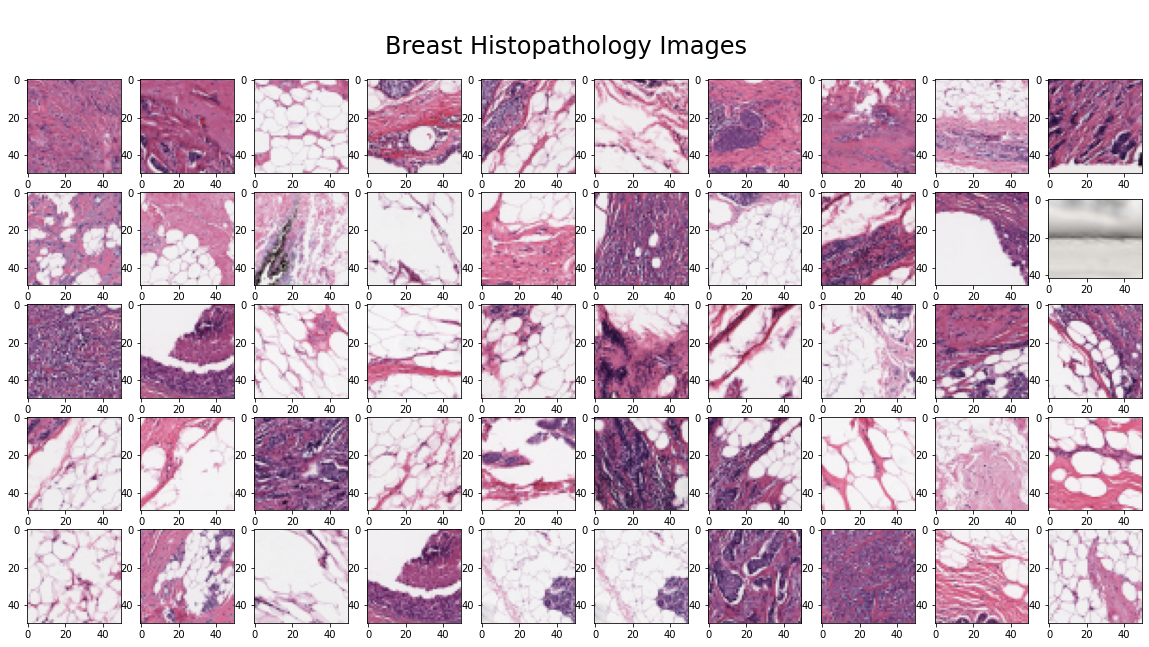

In [2]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/BreastCancerDataset/subsets/BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [3]:
dataset.head()

,patient_ids,labels,images
0,22545,0,"[[[223, 204, 216], [238, 234, 238], [234, 228,..."
1,22545,0,"[[[205, 100, 129], [197, 86, 122], [188, 80, 1..."
2,22545,0,"[[[227, 205, 215], [204, 143, 176], [218, 169,..."
3,22545,0,"[[[239, 227, 230], [234, 197, 214], [240, 229,..."
4,22545,0,"[[[234, 221, 227], [234, 218, 227], [240, 238,..."


In [4]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (2244, 3, 50, 50)
Dims (297, 3, 50, 50)
Dims (234, 3, 50, 50)
Preprocessing completed.


In [5]:
# run this cell
data_subjects_image = np.ones(train["images"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_image[i] = NewDataSubject([str(patient)])

data_subjects_labels = np.ones(train["labels"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_labels[i] = NewDataSubject([str(patient)])

    
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects_image
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects_labels
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [6]:
# from syft import PhiTensor
# def correct_dsl(input_tensor: PhiTensor):
#     """ Corrects for the new DSL shape requirements 
#     e.g. (1915,) -> (1915, 3, 50, 50) 
#     """
#     output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
#     print(output_dsi.shape)
    
#     for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
#         output_dsi[index] *= val
    
#     input_tensor.data_subjects.data_subjects_indexed = output_dsi
#     # print(output_dsi.shape)
#     # print(output_dsi[0])
#     # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
#     # for i in range(input_tensor.shape[0]):
#     #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
#     # input_tensor.data_subjects.data_subjects_indexed = output_dsi

# correct_dsl(train_image_data.child)  
# # .shape, train_image_data.child.data_subjects.shape

In [7]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [8]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [9]:
from syft import nn

In [10]:
input_shape = train_image_data.public_shape
input_shape

(2244, 3, 50, 50)

In [11]:
y_train = train_label_data

In [12]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 3
model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 4
model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 6
model.add(nn.AvgPool(5))

# # Layer 7
model.add(nn.Flatten())

# # Layer 8
model.add(nn.Linear(2))

In [13]:
model.compile()

In [14]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((2244, 3, 50, 50), (2244, 3, 50, 50))

In [15]:
out = train_image_data[:2].child

In [16]:
out.shape, out.data_subjects.shape

((2, 3, 50, 50), (2, 3, 50, 50))

In [17]:
import time
total_time = 0.0
for layer in model.layers:
    start  = time.time()
    print("Layer Name: ", layer)
    out = layer.forward(out)
    end = time.time()
    print(f"Time for Layer: {layer}" , end-start)
    total_time += (end-start)
    print()

Layer Name:  Convolution
Time for Layer: Convolution 4.626079320907593

Layer Name:  BatchNorm


Time for Layer: BatchNorm 3.8943824768066406

Layer Name:  MaxPool
Time for Layer: MaxPool 0.04849100112915039

Layer Name:  Convolution
Time for Layer: Convolution 26.510786771774292

Layer Name:  BatchNorm
Time for Layer: BatchNorm 2.170464038848877

Layer Name:  MaxPool
Time for Layer: MaxPool 0.03418111801147461

Layer Name:  Convolution
Time for Layer: Convolution 35.30831599235535

Layer Name:  BatchNorm
Time for Layer: BatchNorm 1.2996399402618408

Layer Name:  MaxPool
Time for Layer: MaxPool 0.039211273193359375

Layer Name:  Convolution
Time for Layer: Convolution 55.81556677818298

Layer Name:  BatchNorm
Time for Layer: BatchNorm 1.4548673629760742

Layer Name:  MaxPool
Time for Layer: MaxPool 0.02266693115234375

Layer Name:  AvgPool
Time for Layer: AvgPool 0.009665727615356445

Layer Name:  Flatten
Time for Layer: Flatten 0.00012373924255371094

Layer Name:  Linear
Time for Layer: Linear 0.10780882835388184



In [18]:
out.shape, out.data_subjects.shape

((2, 2), (2, 2))

In [19]:
# Total time to execute forward pass
total_time

131.34225130081177

### Loss calculation

In [20]:
out.child.shape

(2, 2)

In [21]:
out.child

DeviceArray([[-3.63822828, -1.66302286],
             [-3.54334522, -1.84773937]], dtype=float64)

In [22]:
y_true = train_label_data[:2].child

In [23]:
y_true

PhiTensor(child=[0 0], min_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>, max_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>)

In [24]:
y_true.shape

(2,)

In [25]:
y_true

PhiTensor(child=[0 0], min_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>, max_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>)

In [26]:
train_label_data.child[:10]

PhiTensor(child=[0 0 0 0 0 0 0 0 0 0], min_vals=<lazyrepeatarray data: [0 0 0 0 0 0 0 0 0 0] -> shape: (10,)>, max_vals=<lazyrepeatarray data: [0 0 0 0 0 0 0 0 0 0] -> shape: (10,)>)

In [27]:
next_grad = model.loss.backward(out, y_true)

In [28]:
next_grad.data_subjects.shape

(2, 2)

In [29]:
total_time_backward = 0.0
for layer in model.layers[::-1]:
    print(layer)
    start = time.time()
    next_grad = layer.backward(next_grad)
    end = time.time()
    print(f"Time to execute backward for {layer}: {end-start}")
    total_time_backward += end-start

Linear
Time to execute backward for Linear: 0.14325618743896484
Flatten
Time to execute backward for Flatten: 0.04630875587463379
AvgPool


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
layer.last_input_shape

In [ ]:
next_grad.data_subjects.shape

In [ ]:
next_grad.shape

In [ ]:
64*14*14

In [ ]:
layer.last_input.T.dot(next_grad) 

In [ ]:
next_grad.data_subjects.shape

In [ ]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)

### Debugging

In [ ]:
import syft as sy

In [ ]:
class DSL:
    __attr_allowlist__ = ("data_subjects",)

    def __init__(self, data_subjects):
        self.data_subjects = set(data_subjects)

    def __add__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __sub__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __mul__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
        
    def __ge__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
    
    def __le__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __truediv__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
    
    def __rtruediv__(self, other):
            return DSL(self.data_subjects)

    def __repr__(self):
        return "DSL: " + str(self.data_subjects.__repr__())
    
    def conjugate(self,*args,**kwargs):
        return DSL(self.data_subjects)
    
    def subtract(self,x,y,*args, **kwargs):
        if isinstance(y, DSL) and isinstance(x,DSL):
            return DSL(x.data_subjects.union(y.data_subjects))
        elif isinstance(y, DSL):
            return DSL(y.data_subjects)
        elif isinstance(x, DSL):
            return DSL(x.data_subjects)
    
    def multiply(self,x,y,*args, **kwargs):
        if isinstance(y, DSL) and isinstance(x,DSL):
            return DSL(x.data_subjects.union(y.data_subjects))
        elif isinstance(y, DSL):
            return DSL(y.data_subjects)
        elif isinstance(x, DSL):
            return DSL(x.data_subjects)
    
    def real(self):
        return DSL(self.data_subjects)

    def var(self,*args, **kwargs):
        return  ((self  - np.mean(self))*(self  - np.mean(self)))

    def sqrt(self,*args, **kwargs):
        return DSL(self.data_subjects)

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        method_name = ufunc.__name__
        print("method_name",method_name)
        method  = getattr(self,method_name,None)
        if method is not None:
            return method(*inputs, **kwargs)
        else:
            raise NotImplementedError(f"Method: {method_name} not implemented in DSL")
        

        
            

In [ ]:
from syft.core.adp.data_subject_list import NewDataSubject

In [ ]:
a = np.array([["ishan","shubham"],["ishan","shubham"]])

In [ ]:
a>0

In [ ]:
squarer = lambda t: NewDataSubject([t])

In [ ]:
v = np.vectorize(squarer)

In [ ]:
dsl = v(a)

In [ ]:
dsl.__gt__(0)

In [ ]:
dsl.mean(dsl)

In [ ]:
np.fliplr(dsl)

In [ ]:
val = np.random.random((3,5,5))
print(val)
print(np.fliplr(val))

In [ ]:
np.fliplr(val)

In [ ]:
import numpy as np

In [ ]:
np.array(DSL("A"))/np.array([1])

In [ ]:
axis=None, dtype=None, out=None,keepdims=False,where=True

In [ ]:
ret = np.add.reduce(np.array(DSL("A")), axis=None, dtype=None, out=None,keepdims=False,where=True)

In [ ]:
ret/5

In [ ]:
from syft.core.adp.data_subject_list import NewDataSubject as DSL

In [ ]:
import syft as sy

In [ ]:
sy.deserialize(sy.serialize(DSL("A")))

In [ ]:
import numpy as np

In [ ]:
a = np.array([ [ [DSL("A"),DSL("B")], [DSL("C"),DSL("D") ]],[[DSL("A"),DSL("B")], [DSL("C"),DSL("D") ]]])

In [ ]:
np.squeeze(a,None)

In [ ]:
np.maximum(a,a)

In [ ]:
b = np.array([[1,2],[3,4]])

In [ ]:
sy.deserialize(sy.serialize(a.tolist()))

In [ ]:
b = np.array([ [DSL("B"),DSL("B")], [DSL("C"),DSL("C") ]])

In [ ]:
a

In [ ]:
b

In [ ]:
a.mean(axis=0)

In [ ]:
a.dot(np.array([[1,2],[3,4]]))

In [ ]:
a

In [ ]:
from syft import PhiTensor

In [ ]:
import numpy as np

In [ ]:
data_subjects1 = [["cicada","cicada"],["cicada","cicada"]]
data_subjects2 = [["3301","3301"],["3301","3301"]]

In [ ]:
a = PhiTensor(child = np.array([[1,2],[3,4]]),min_vals = 1,max_vals=4,data_subjects=data_subjects1)
b = PhiTensor(child = np.array([[1,2],[3,4]]),min_vals = 1,max_vals=4,data_subjects=data_subjects2)

In [ ]:
a.data_subjects

In [ ]:
b.data_subjects

In [ ]:
v = a+b

In [ ]:
v.data_subjects

In [ ]:
np.std(b,axis=0)

In [ ]:
c  = np.array([[1,1,1],[1,1,1]])

In [ ]:
np.conjugate(c)

In [ ]:
b.dot(c)

In [ ]:
np.array(a.mean())

In [ ]:
x = np.array([[1,2,3]])

In [ ]:
y = np.array([[4]])

In [ ]:
x+y

In [ ]:
x = np.array([[DSL("1"),DSL("2"),DSL("3")]])

In [ ]:
y = np.array([[DSL("4")]])

In [ ]:
x+y